# **Motion Magic Studios: Film Analysis**

<img src="https://images.unsplash.com/photo-1598899134739-24c46f58b8c0?auto=format&fit=crop&q=80&w=2912&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="title image" width="700" height="400" />


# Overview

Motion Magic Studios is embarking on an exciting venture into the world of cinema. In this strategic analysis, our goal is to provide valuable insights and recommendations to guide the company in establishing it's new movie studio. Our approach is centered on the study of recent trends in the movie industry, with a particular focus on factors contributing to box office success. Motion Magic Studios can use this analysis to decide what type of films to create. 


# Business Problem

 The main focus for the company is profitability, particularly in the early years. We aim to find the most profitale genre with a mid tier studio budget of $80 million. Additionally, we will investigate the optimal month for movie releases and analyze the correlation between production budget and profitability to inform our strategic decisions.


<img src="https://images.unsplash.com/photo-1543536448-d209d2d13a1c?auto=format&fit=crop&q=80&w=2940&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" alt="film image" width="700" height="400" />


# Data Understanding

The data comes from multiple different film databases and sources - [IMDB](https://www.imdb.com/), [The Numbers](https://www.the-numbers.com/), [Box Office Mojo](https://www.boxofficemojo.com/), [Rotten Tomatoes](https://www.rottentomatoes.com/) and [TheMovieDB](https://www.themoviedb.org/).

For our conditions - we focused on films released between the years 2000-2020, calculated return on investment (ROI) and with a production budget of $80 million or under. 

Some of the limitations of our data include ambiguous data for some observations, financials adjusted for inflation and data integration challenges. 

In [89]:
#import all the packages
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pandas as pd
import numpy as np

import sqlite3
import zipfile

import warnings
warnings.filterwarnings('ignore')


from mpl_toolkits.mplot3d import Axes3D
from random import gauss, seed

from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm

# Movie Industry Data
For our master dataset, we identified [The Numbers](https://www.the-numbers.com/) and [IMDB](https://www.imdb.com/) as the ones needed for our analysis. These include information on title, genres, production budget, domestic and worldwide gross.


In [90]:
# Read in movie budgets dataset
movie_budgets = pd.read_csv('data/tn.movie_budgets.csv.gz')
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [91]:
# Connect and Read in IMDb SQL tables
conn = sqlite3.connect('im.db.zip')
zip_file_path = 'data/im.db.zip'

with zipfile.ZipFile('data/im.db.zip', 'r') as zip_ref:
    zip_ref.extractall('unzippedData')

database_path = 'unzippedData/im.db'
conn = sqlite3.connect(database_path)

In [92]:
schema_df = pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type= "table";

""", conn)

schema_df

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [93]:
# Reading the IMDb movie_basics table
movie_basics = pd.read_sql(
    """
    SELECT *
    FROM movie_basics
    WHERE start_year <= 2020
    """, conn
)
movie_basics

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146013,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146014,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146015,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146016,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [94]:
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


# Data Cleaning and Filtering
To prepare our data, we are parsing the release date into new columns and filtering a new dateframe to include the conditions of our business problem and dropping unnecessary columns. 

In [95]:
# Create new columns for release year and release month from release date
movie_budgets['release_year'] = movie_budgets['release_date'].str[-4:].astype(int)
movie_budgets['release_month'] = movie_budgets['release_date'].str.split().str[0]

In [96]:
# Sanity Check
movie_budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,May
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,Dec


In [97]:
# Filter for release year equal and above to year 2000
movie_budgets_filtered = movie_budgets[movie_budgets['release_year'] >= 2000]
movie_budgets_filtered 

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",2009,Dec
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",2011,May
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",2019,Jun
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",2015,May
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",2017,Dec
...,...,...,...,...,...,...,...,...
5776,77,"Dec 31, 2004",The Mongol King,"$7,000",$900,$900,2004,Dec
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,2018,Dec
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",2005,Jul
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,2015,Sep


Normalizing relevant column names and values

In [128]:
# Remove the dollar sign and commas, then convert the values to integers
movie_budgets_filtered['production_budget'] = movie_budgets_filtered['production_budget'].astype(str)
movie_budgets_filtered['production_budget'] = movie_budgets_filtered['production_budget'].str.replace('$', '').str.replace(',', '').astype(int)
movie_budgets_filtered['worldwide_gross'] = movie_budgets_filtered['worldwide_gross'].astype(str)
movie_budgets_filtered['worldwide_gross'] = movie_budgets_filtered['worldwide_gross'].str.replace('$', '').str.replace(',', '').astype(int)
movie_budgets_filtered['domestic_gross'] = movie_budgets_filtered['domestic_gross'].astype(str)
movie_budgets_filtered['domestic_gross'] = movie_budgets_filtered['domestic_gross'].str.replace('$', '').str.replace(',', '').astype(int)

In [129]:
# Sanity Check
movie_budgets_filtered.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,2351345279,553.26
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,1072413963,324.38
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,999721747,315.37
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,Dec,1747311220,571.02
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,Apr,1748134200,582.71


# Feature Engineering

In [130]:
# Create profit column
movie_budgets_filtered['profit'] = movie_budgets_filtered['worldwide_gross'] - movie_budgets_filtered['production_budget']
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,2351345279,553.26
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,1072413963,324.38
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,999721747,315.37
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,Dec,1747311220,571.02
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,Apr,1748134200,582.71
...,...,...,...,...,...,...,...,...,...,...
5766,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,128711,1287.11
5767,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,84596,845.96
5774,75,"Oct 8, 2004",Primer,7000,424760,841926,2004,Oct,834926,11927.51
5775,76,"May 26, 2006",Cavite,7000,70071,71644,2006,May,64644,923.49


In [131]:
# Create return on investment (ROI) column and turn it into a percentage
movie_budgets_filtered['roi'] = round((movie_budgets_filtered['profit'] / movie_budgets_filtered['production_budget']) * 100, 2)
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,2351345279,553.26
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,1072413963,324.38
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,999721747,315.37
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,Dec,1747311220,571.02
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,Apr,1748134200,582.71
...,...,...,...,...,...,...,...,...,...,...
5766,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,128711,1287.11
5767,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,84596,845.96
5774,75,"Oct 8, 2004",Primer,7000,424760,841926,2004,Oct,834926,11927.51
5775,76,"May 26, 2006",Cavite,7000,70071,71644,2006,May,64644,923.49


In [132]:
# Checking central tendency measures
movie_budgets_filtered['roi'].describe()

count     1267.000000
mean       810.178082
std       2245.679410
min        200.080000
25%        282.060000
50%        411.650000
75%        699.145000
max      43051.790000
Name: roi, dtype: float64

In [133]:
# Filtering roi above 200.0 percent, indicating the profit is at least 2 times the production budget.
movie_budgets_filtered = movie_budgets_filtered[movie_budgets_filtered["roi"] >= 200.0]
movie_budgets_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279,2009,Dec,2351345279,553.26
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963,2015,May,1072413963,324.38
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,Dec,999721747,315.37
5,6,"Dec 18, 2015",Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,Dec,1747311220,571.02
6,7,"Apr 27, 2018",Avengers: Infinity War,300000000,678815482,2048134200,2018,Apr,1748134200,582.71
...,...,...,...,...,...,...,...,...,...,...
5766,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,128711,1287.11
5767,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,84596,845.96
5774,75,"Oct 8, 2004",Primer,7000,424760,841926,2004,Oct,834926,11927.51
5775,76,"May 26, 2006",Cavite,7000,70071,71644,2006,May,64644,923.49


In [134]:
# Filter observations where the production_budget is less than or equal to $80M according to our conditions
budgets = movie_budgets_filtered[movie_budgets_filtered['production_budget'] <= 80000000]
budgets

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi
537,38,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,597923379,747.40
538,39,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,506464305,633.08
540,41,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,230660018,288.33
541,42,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,389500298,486.88
544,45,"May 19, 2006",Over the Hedge,80000000,155019340,343397247,2006,May,263397247,329.25
...,...,...,...,...,...,...,...,...,...,...
5766,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,128711,1287.11
5767,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,84596,845.96
5774,75,"Oct 8, 2004",Primer,7000,424760,841926,2004,Oct,834926,11927.51
5775,76,"May 26, 2006",Cavite,7000,70071,71644,2006,May,64644,923.49


In [135]:
# Sanity check
budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058 entries, 537 to 5781
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1058 non-null   int64  
 1   release_date       1058 non-null   object 
 2   movie              1058 non-null   object 
 3   production_budget  1058 non-null   int64  
 4   domestic_gross     1058 non-null   int64  
 5   worldwide_gross    1058 non-null   int64  
 6   release_year       1058 non-null   int64  
 7   release_month      1058 non-null   object 
 8   profit             1058 non-null   int64  
 9   roi                1058 non-null   float64
dtypes: float64(1), int64(6), object(3)
memory usage: 90.9+ KB


In [136]:
# Create new dataframe and Merge with IMDB movie_basics table
merged_df_copy = pd.merge(budgets, movie_basics, left_on='movie', right_on='primary_title', how='inner')
merged_df_copy

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,38,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,597923379,747.40,tt1392170,The Hunger Games,The Hunger Games,2012,142.0,"Action,Adventure,Sci-Fi"
1,39,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,506464305,633.08,tt1411697,The Hangover Part II,The Hangover Part II,2011,102.0,"Comedy,Mystery"
2,41,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,230660018,288.33,tt4116284,The Lego Batman Movie,The Lego Batman Movie,2017,104.0,"Action,Animation,Comedy"
3,42,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,389500298,486.88,tt2510894,Hotel Transylvania 2,Hotel Transylvania 2,2015,89.0,"Animation,Comedy,Family"
4,48,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,167023808,208.78,tt2191701,Grown Ups 2,Grown Ups 2,2013,101.0,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,49,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,464792,1859.17,tt2782686,Exeter,Exeter,2014,NaN,Horror
770,49,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,464792,1859.17,tt4931374,Exeter,Exeter,2015,92.0,None
771,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,128711,1287.11,tt6619196,Clean,Clean,2017,70.0,"Comedy,Drama,Horror"
772,68,"Jul 6, 2001",Cure,10000,94596,94596,2001,Jul,84596,845.96,tt1872026,Cure,Cure,2011,93.0,Drama


In [137]:
# Drop duplicates from new dataframe
merge_copy = merged_df_copy.drop_duplicates(subset=['movie'])
merge_copy

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,38,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,597923379,747.40,tt1392170,The Hunger Games,The Hunger Games,2012,142.0,"Action,Adventure,Sci-Fi"
1,39,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,506464305,633.08,tt1411697,The Hangover Part II,The Hangover Part II,2011,102.0,"Comedy,Mystery"
2,41,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,230660018,288.33,tt4116284,The Lego Batman Movie,The Lego Batman Movie,2017,104.0,"Action,Animation,Comedy"
3,42,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,389500298,486.88,tt2510894,Hotel Transylvania 2,Hotel Transylvania 2,2015,89.0,"Animation,Comedy,Family"
4,48,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,167023808,208.78,tt2191701,Grown Ups 2,Grown Ups 2,2013,101.0,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,38,"Mar 18, 2016",Krisha,30000,144822,144822,2016,Mar,114822,382.74,tt4266638,Krisha,Krisha,2015,83.0,Drama
767,48,"Jan 14, 2000",The Terrorist,25000,195043,195043,2000,Jan,170043,680.17,tt9248762,The Terrorist,The Terrorist,2018,NaN,Thriller
768,49,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,464792,1859.17,tt1945044,Exeter,Exeter,2015,91.0,"Horror,Mystery,Thriller"
771,67,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,128711,1287.11,tt6619196,Clean,Clean,2017,70.0,"Comedy,Drama,Horror"


In [138]:
# Dropping unnecessary columns
merge_copy.drop(columns = ["id", "start_year", "original_title", "runtime_minutes"], inplace = True)

In [139]:
# Rename the dataframe to appropriate name and save cleaned dataset as CSV
movie_df = merge_copy
movie_df.to_csv('data/movie.df.csv', index=False)

In [140]:
# Sanity check
movie_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi,movie_id,primary_title,genres
0,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,597923379,747.40,tt1392170,The Hunger Games,"Action,Adventure,Sci-Fi"
1,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,506464305,633.08,tt1411697,The Hangover Part II,"Comedy,Mystery"
2,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,230660018,288.33,tt4116284,The Lego Batman Movie,"Action,Animation,Comedy"
3,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,389500298,486.88,tt2510894,Hotel Transylvania 2,"Animation,Comedy,Family"
4,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,167023808,208.78,tt2191701,Grown Ups 2,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...
766,"Mar 18, 2016",Krisha,30000,144822,144822,2016,Mar,114822,382.74,tt4266638,Krisha,Drama
767,"Jan 14, 2000",The Terrorist,25000,195043,195043,2000,Jan,170043,680.17,tt9248762,The Terrorist,Thriller
768,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,464792,1859.17,tt1945044,Exeter,"Horror,Mystery,Thriller"
771,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,128711,1287.11,tt6619196,Clean,"Comedy,Drama,Horror"


In [141]:
movie_df["genres"].value_counts()

Drama                       36
Horror,Mystery,Thriller     25
Comedy,Drama,Romance        24
Documentary                 21
Comedy,Drama                21
                            ..
Documentary,Family           1
Action,Comedy,Horror         1
Action,Drama,Family          1
Action,Adventure,Mystery     1
Horror,Romance,Thriller      1
Name: genres, Length: 141, dtype: int64

# Visual Analysis

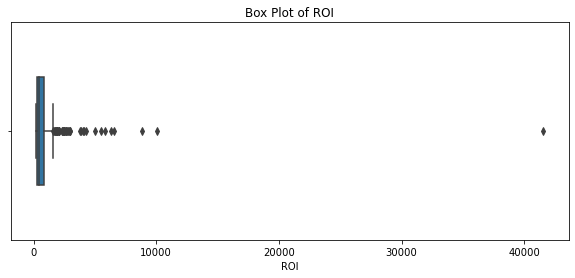

In [142]:
# Using box plot to see any outliers

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=movie_df['roi'], ax=ax, width=0.5)
ax.set_title('Box Plot of ROI')
ax.set_xlabel('ROI')
plt.show()

The box plot shows that most of the data lies within the 95% IQR range. There are a few outliers that represent movies with exceptionally high or low ROI compared to the rest. We address those next.

In [143]:
# Addressing the max outlier
max_value = movie_df['roi'].max()
movie_df = movie_df[movie_df['roi'] != max_value]

In [144]:
# Sanity Check
movie_df

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,profit,roi,movie_id,primary_title,genres
0,"Mar 23, 2012",The Hunger Games,80000000,408010692,677923379,2012,Mar,597923379,747.40,tt1392170,The Hunger Games,"Action,Adventure,Sci-Fi"
1,"May 26, 2011",The Hangover Part II,80000000,254464305,586464305,2011,May,506464305,633.08,tt1411697,The Hangover Part II,"Comedy,Mystery"
2,"Feb 10, 2017",The Lego Batman Movie,80000000,175750384,310660018,2017,Feb,230660018,288.33,tt4116284,The Lego Batman Movie,"Action,Animation,Comedy"
3,"Sep 25, 2015",Hotel Transylvania 2,80000000,169700110,469500298,2015,Sep,389500298,486.88,tt2510894,Hotel Transylvania 2,"Animation,Comedy,Family"
4,"Jul 12, 2013",Grown Ups 2,80000000,133668525,247023808,2013,Jul,167023808,208.78,tt2191701,Grown Ups 2,Comedy
...,...,...,...,...,...,...,...,...,...,...,...,...
766,"Mar 18, 2016",Krisha,30000,144822,144822,2016,Mar,114822,382.74,tt4266638,Krisha,Drama
767,"Jan 14, 2000",The Terrorist,25000,195043,195043,2000,Jan,170043,680.17,tt9248762,The Terrorist,Thriller
768,"Sep 1, 2015",Exeter,25000,0,489792,2015,Sep,464792,1859.17,tt1945044,Exeter,"Horror,Mystery,Thriller"
771,"Apr 28, 2006",Clean,10000,138711,138711,2006,Apr,128711,1287.11,tt6619196,Clean,"Comedy,Drama,Horror"


First, we focus on different genres and compare the ROI impact they had. We are looking to make movies with a budget of $80M, so the movies that fall under the "Horror, Mystery, Thriller" genre and Drama stand out. 

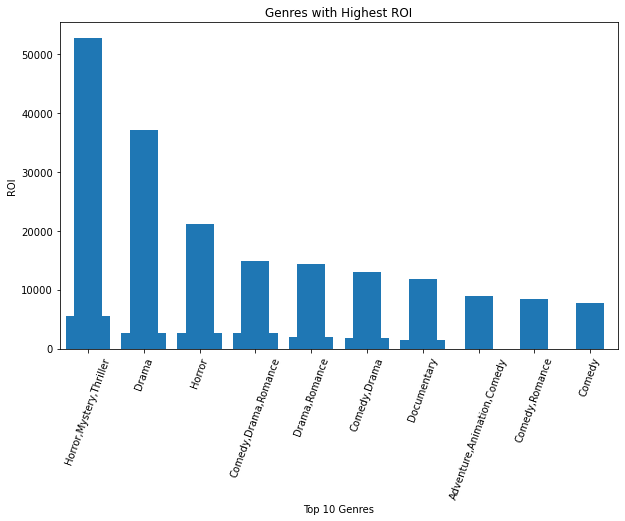

In [145]:
# Bar chart for top 10 genres
plt.figure(figsize=(10, 6))
top_10_genre = movie_df.groupby("genres")["roi"].sum().sort_values(ascending = False).head(10)
top_10_genre.plot(kind = "bar")
top_genre_highest_roi = movie_df.groupby('genres')['roi'].median().sort_values(ascending=False).head(7)
plt.bar(top_genre_highest_roi.index, top_genre_highest_roi.values)
plt.xlabel('Top 10 Genres')
plt.ylabel('ROI')
plt.title('Genres with Highest ROI')
plt.xticks(rotation=70)
plt.show()

Next we looked at which month had the highest profit. June and July are the most profitable. 

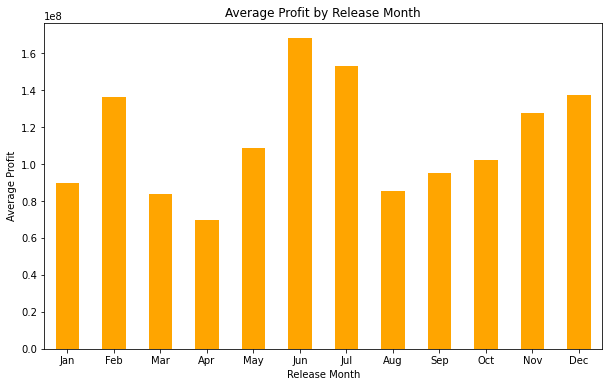

In [146]:
# Bar chart for Profit across release months
profit_month = movie_df.groupby('release_month')['profit'].mean().reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Create a bar plot
plt.figure(figsize=(10, 6))
profit_month.plot(kind='bar', color='orange')
plt.title('Average Profit by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Profit')
plt.xticks(rotation=0)
plt.show()

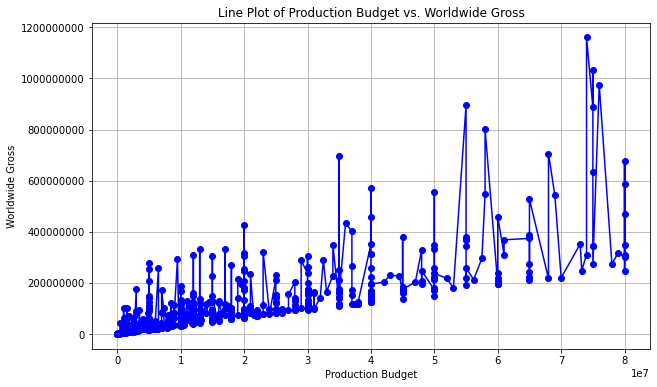

In [147]:
roi_sorted = movie_df.sort_values(by='production_budget')

# Extract the data
production_budget = roi_sorted['production_budget']
worldwide_gross = roi_sorted['worldwide_gross']

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(production_budget, worldwide_gross, color='blue', marker='o', linestyle='-')
plt.title('Line Plot of Production Budget vs. Worldwide Gross')
plt.xlabel('Production Budget')
plt.ylabel('Worldwide Gross')

# Format the y-axis labels to display full numbers, not in scientific notation
plt.ticklabel_format(style='plain', axis='y')

plt.grid(True)
plt.show()

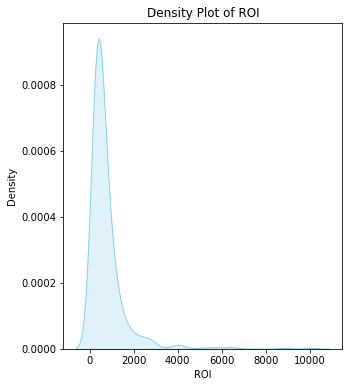

In [148]:
plt.figure(figsize=(5, 6))
sns.kdeplot(movie_df['roi'], color='skyblue', shade=True)
plt.title('Density Plot of ROI')
plt.xlabel('ROI')
plt.ylabel('Density')
plt.show()

In [149]:
# Calculate central tendency measures - mean, median, mode
movie_df['roi'].describe()

count      513.000000
mean       751.409688
std        968.504370
min        200.860000
25%        288.050000
50%        445.120000
75%        806.890000
max      10075.950000
Name: roi, dtype: float64

# Hypothesis Testing
Hypothesis Test between production budget and ROI.

* **Alternative Hypothesis:** There is a significant difference between production budget and ROI.

* **Null Hypothesis:** There is no difference between production budget and ROI.

In [150]:
# Correlation Coefficient to see relation between production_budget and profit

corr_coeff = np.corrcoef(movie_df['production_budget'], movie_df['profit'])[0, 1]
print(f"Pearson's correlation coefficient: {corr_coeff:.2f}")


Pearson's correlation coefficient: 0.67


 Since we are measuring 2 continuous variables, we look at Pearson's r. A correlation coefficient of 0.67 suggests a moderate positive linear relationship between production budget and profit. 
- As the correlation coefficient is positive (greater than 0), it indicates that as the production budget increases, there tends to be an increase in profit as we expected. In other words, movies with higher production budgets tend to have higher profit earnings.
- However, the correlation is not very strong (0.67 is less than 1), so while there is a positive relationship, there is still variability in the data, and other factors may influence profit as well.

In [151]:
from scipy.stats import pearsonr
roi = movie_df['roi']
production_budget = movie_df['production_budget']


correlation_coefficient, p_value = pearsonr(roi, production_budget)


print("Correlation Coefficient:", correlation_coefficient)
print("P-Value:", p_value)

# Set alpha level
alpha = 0.05

# Check if the p-value is less than alpha to reject the null hypothesis
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant correlation between ROI and Production Budget.")
else:
    print("Fail to reject the null hypothesis: There is no significant correlation between ROI and Production Budget.")


Correlation Coefficient: -0.25852945592939647
P-Value: 2.805335894738774e-09
Reject the null hypothesis: There is a significant correlation between ROI and Production Budget.


As the p-value is less than alpha, we reject the null hypothesis. The results show there is a statistically significant difference between ROI and production budget. 

# Linear Regression

First, we want to look at how movie budgets affect profits for our entire data set. Not surprisingly, the R-value of .66 shows some positive correlation between spending money on a movie and earning profits.

In [122]:
# Simple linear regression for all movies
slope, intercept, r_value, p_value, std_err = linregress(movie_df["production_budget"], movie_df["profit"])

print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard Error:", std_err)

Slope: 4.41940644473459
Intercept: 16710944.076928765
R-value: 0.6691813266121206
P-value: 6.696275641457735e-68
Standard Error: 0.21709831249904837


In [123]:
# Simple Linear Regression budget vs profit
X = movie_df['production_budget']
y = movie_df['profit']
X = sm.add_constant(X)
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     414.4
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           6.70e-68
Time:                        13:51:46   Log-Likelihood:                -10179.
No. Observations:                 513   AIC:                         2.036e+04
Df Residuals:                     511   BIC:                         2.037e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.671e+07    6.5e+06      2.570      0.010    3.94e+06    2.95e+07
production_budget     4.4194      0.217     20.357      0.000       3.993       4.846
==============================================================================
Omnibus:                      364.120   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5141.560
Skew:                           2.980   Prob(JB):                         0.00
Kurtosis:                      17.318   Cond. No.                     4.39e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Production budget explains a 44% variance in profit. As you can the more money you invest, the higher the returns are. There is a significant positive correlation as we expected. But that’s not always the case. Even with a lower end budget you can have higher significant returns. The studio can assess the risk vs reward. There are also some outliers above the trend line; we see the $80M movies made a profit of a $1B. 


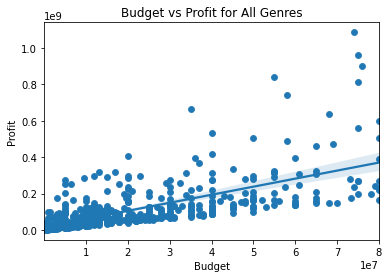

In [124]:
# Plotting the best fit line

sns.scatterplot(x='production_budget', y='profit', data=movie_df)
sns.regplot(data = movie_df, x = "production_budget", y = "profit")
plt.xlabel("Budget")
plt.ylabel("Profit")
plt.title("Budget vs Profit for All Genres")
plt.show()


Next we look at a linear Regression between production budget and worldwide gross. The r-value of 0.74 indicates a strong positive correlation between higher investments in movies and achieving higher gross revenue. 

In [125]:
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(movie_df["production_budget"], movie_df["worldwide_gross"])
print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)
print("Standard Error:", std_err)

Slope: 5.419406444734587
Intercept: 16710944.076928824
R-value: 0.7412429738729985
P-value: 1.6232317228375647e-90
Standard Error: 0.21709831249904832


In [126]:
# Simple Linear Regression
X = movie_df['production_budget']
y = movie_df['worldwide_gross']
X = sm.add_constant(X)
model = sm.OLS(y, X)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        worldwide_gross   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     623.1
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           1.62e-90
Time:                        13:51:46   Log-Likelihood:                -10179.
No. Observations:                 513   AIC:                         2.036e+04
Df Residuals:                     511   BIC:                         2.037e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.671e+07    6.5e+06      2.570      0.010    3.94e+06    2.95e+07
production_budget     5.4194      0.217     24.963      0.000       4.993       5.846
==============================================================================
Omnibus:                      364.120   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5141.560
Skew:                           2.980   Prob(JB):                         0.00
Kurtosis:                      17.318   Cond. No.                     4.39e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The production budget explains 54% of the variation in worldwide gross. P-value is less than 0. Therefore we reject null and find evidence that there is a significant difference between the 2 variables. It is a positive correlation. 

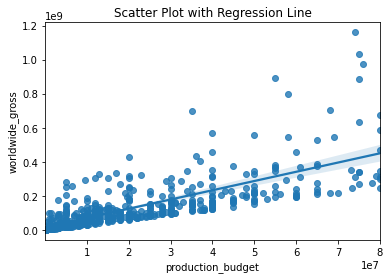

In [127]:
# Scatter plot with regression line
sns.regplot(x='production_budget', y='worldwide_gross', data=movie_df)
plt.title('Scatter Plot with Regression Line')
plt.show()

# Recommendations
* Create a movie that falls in the "Horror, Mystery, Thriller" genre. 
As a start-up movie studio, the focus should be this genre due to the box office sucess over the years. 

* Create a Drama is the second highest grossing genre. 

* Premier movies in June to see the highest returns on investment. 



# Next Steps

Marketing
* Conduct a thorough marketing analysis to identify effective promotional strategies, which may include movie trailers, media advertising, and social media engagement. This analysis is crucial for building anticipation and excitement around new films.

Distribution
* Explore potential collaborations with larger production companies for distribution. Such partnerships can provide broader exposure and strategic placement of high-budget movies, extending into international markets.

Identifying and collaborating with successful directors in the film industry can be a strategic move for a studio aiming for box office success. 
